In [1]:
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Define augmentation generators

all_classes_datagen = ImageDataGenerator(rescale= 1/255)

aggressive_datagen = ImageDataGenerator(rescale= 1/255,
        rotation_range=15,
        width_shift_range=-0.1,
        height_shift_range=-0.1,
        shear_range=0.1)

specific_datagen = ImageDataGenerator(rescale= 1/255,
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        horizontal_flip=True)

In [3]:
all_classes_generator = all_classes_datagen.flow_from_directory('train/all classes',
        target_size = (48,48),
        batch_size = 64,
        color_mode = 'grayscale',
        class_mode = 'categorical'
)

aggressive_generator = aggressive_datagen.flow_from_directory('train/aggressive',
        target_size = (48,48),
        batch_size = 64,
        color_mode = 'grayscale',
        class_mode = 'categorical'
)

specific_generator = specific_datagen.flow_from_directory('train/specific',
        target_size = (48,48),
        batch_size = 64,
        color_mode = 'grayscale',
        class_mode = 'categorical'
)

Found 28030 images belonging to 5 classes.
Found 10194 images belonging to 5 classes.
Found 2466 images belonging to 5 classes.


In [4]:
print(all_classes_generator.class_indices)
print(aggressive_generator.class_indices)
print(specific_generator.class_indices)

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}
{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}
{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}


In [5]:
import numpy as np

# Extract all images and labels from all batches
all_images = []
all_labels = []

for i in range(len(all_classes_generator)):
    batch_images, batch_labels = all_classes_generator[i]
    all_images.append(batch_images)
    all_labels.append(batch_labels)
    
for i in range(len(aggressive_generator)):
    batch_images, batch_labels = aggressive_generator[i]
    all_images.append(batch_images)
    all_labels.append(batch_labels)
    
for i in range(len(specific_generator)):
    batch_images, batch_labels = specific_generator[i]
    all_images.append(batch_images)
    all_labels.append(batch_labels)
    
# Concatenate all batches
all_images = np.concatenate(all_images)
all_labels = np.concatenate(all_labels)

print(len(all_images))
print(len(all_labels))

40690
40690


In [6]:
print(all_images.shape)
print(all_labels.shape)

(40690, 48, 48, 1)
(40690, 5)


In [7]:
import pandas as pd

# Decode one-hot encoded labels to integer labels
decoded_labels = np.argmax(all_labels, axis=1)

# Convert numpy array to pandas Series
labels_series = pd.Series(decoded_labels)

# Calculate value counts
value_counts = labels_series.value_counts()

# Print the value counts
print(value_counts)

2    10308
4     8428
1     7528
0     7398
3     7028
dtype: int64


C:\Users\POGBA\anaconda3\lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Text(0.5, 1.0, '[1. 0. 0. 0. 0.]')

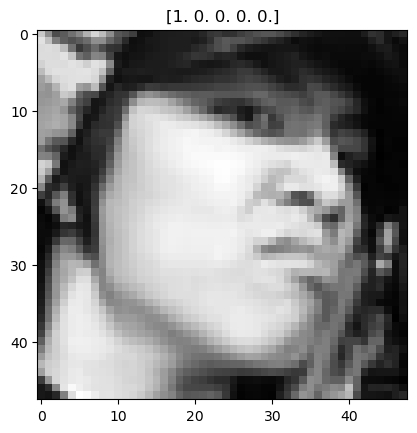

In [8]:
import matplotlib.pyplot as plt

plt.imshow(all_images[50], 'gray')
plt.title(all_labels[50])

In [9]:
from sklearn.model_selection import train_test_split

train_images, val_images, train_labels, val_labels = train_test_split(all_images, all_labels,
                                                                      test_size=0.15,
                                                                      random_state=42)

In [10]:
print('training =', len(train_labels))
print('validation =', len(val_labels))

training = 34586
validation = 6104


In [11]:
print('training =', train_images.shape)
print('validation =', val_images.shape)

training = (34586, 48, 48, 1)
validation = (6104, 48, 48, 1)


In [12]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.shuffle(buffer_size=10000).batch(64).repeat()

validation_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
validation_dataset = validation_dataset.shuffle(buffer_size=10000).batch(64).repeat()

In [13]:
train_dataset

<_RepeatDataset element_spec=(TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [14]:
from keras.applications import ResNet50
from keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

In [15]:
base_model = ResNet50(weights='imagenet', include_top=False)

# Modify the input shape of the first layer to accept grayscale images
new_input = Input(shape=(48, 48, 1))
x = Conv2D(3, (3, 3), padding='same')(new_input)  # Convert 1 channel to 3 channels
output = base_model(x)

In [16]:
x = GlobalAveragePooling2D()(output)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)

# Create the model
model = Model(inputs=new_input, outputs=predictions)

In [17]:
for layer in model.layers:
    layer.trainable = False

# Optionally unfreeze all layers for fine-tuning
for layer in model.layers[-10:]:
    layer.trainable = True

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, clipvalue=5), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 48, 48, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 48, 48, 3)         30        
                                                                 
 resnet50 (Functional)       (None, None, None, 2048   23587712  
                             )                                   
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              209817

In [19]:
# Define the callback
#checkpoint_callback = ModelCheckpoint(
#    filepath='model_weights.h5',
#    monitor='val_accuracy',
#    save_best_only=True,
#    save_weights_only=True,
#    mode='max',
#    verbose=1)

history = model.fit(train_dataset,
                             steps_per_epoch= 34586 // 64,
                             epochs= 15,
                             validation_data= validation_dataset,
                             validation_steps= 6104 // 64)
                             #callbacks= [checkpoint_callback]
                   #)

Epoch 1/15
540/540 [==============================] - 799s 1s/step - loss: 1.2473 - accuracy: 0.5266 - val_loss: 11.8204 - val_accuracy: 0.2490
Epoch 2/15
540/540 [==============================] - 773s 1s/step - loss: 0.7098 - accuracy: 0.7331 - val_loss: 0.9146 - val_accuracy: 0.6475
Epoch 3/15
540/540 [==============================] - 771s 1s/step - loss: 0.4718 - accuracy: 0.8257 - val_loss: 0.7228 - val_accuracy: 0.7512
Epoch 4/15
540/540 [==============================] - 773s 1s/step - loss: 0.3256 - accuracy: 0.8804 - val_loss: 0.8161 - val_accuracy: 0.7382
Epoch 5/15
540/540 [==============================] - 792s 1s/step - loss: 0.2331 - accuracy: 0.9167 - val_loss: 0.8100 - val_accuracy: 0.7605
Epoch 6/15
540/540 [==============================] - 773s 1s/step - loss: 0.1716 - accuracy: 0.9392 - val_loss: 0.9879 - val_accuracy: 0.7464
Epoch 7/15
540/540 [==============================] - 795s 1s/step - loss: 0.1433 - accuracy: 0.9483 - val_loss: 0.9017 - val_accuracy: 0.772

In [20]:
test_datagen = ImageDataGenerator(rescale = 1/255)

test_generator = test_datagen.flow_from_directory('test',
        target_size = (48,48),
        batch_size = 64,
        color_mode = 'grayscale',
        class_mode = 'categorical'
)

Found 6991 images belonging to 5 classes.


In [21]:
test_generator.class_indices

{'anger': 0, 'happiness': 1, 'neutral': 2, 'sadness': 3, 'startle': 4}

In [22]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(test_loss, test_accuracy)

110/110 [==============================] - 51s 454ms/step - loss: 1.2708 - accuracy: 0.7181
1.270769476890564 0.7180660963058472


In [23]:
val_loss, val_accuracy = model.evaluate(val_images, val_labels)
print(val_loss, val_accuracy)

191/191 [==============================] - 18s 96ms/step - loss: 0.9677 - accuracy: 0.7751
0.9677342176437378 0.775065541267395


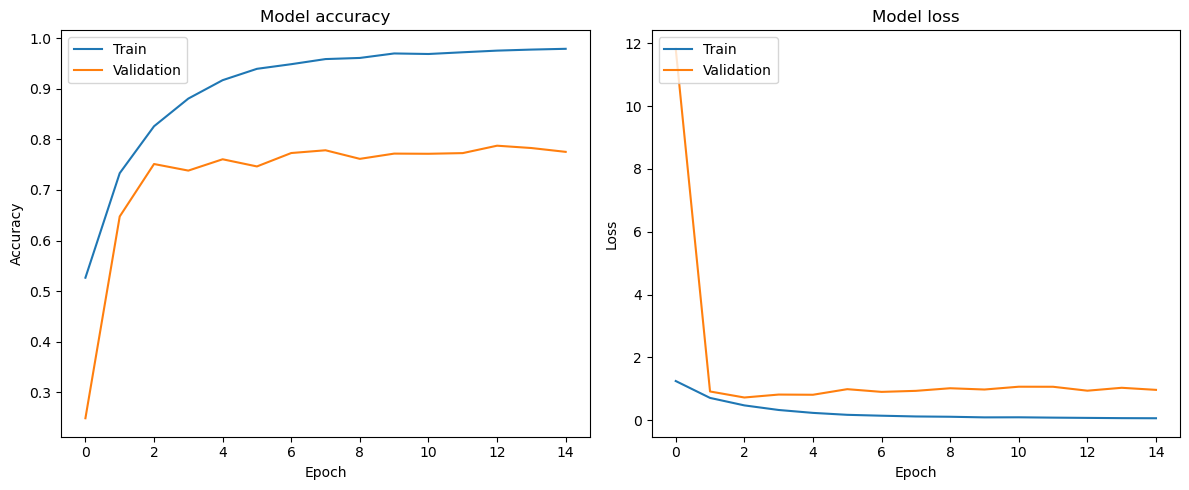

In [24]:
import matplotlib.pyplot as plt

# Create subplots with 1 row and 2 columns
plt.figure(figsize=(12, 5))

# Plot accuracy subplot
plt.subplot(1, 2, 1)  # (rows, columns, index)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss subplot
plt.subplot(1, 2, 2)  # (rows, columns, index)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [25]:
model_json = model.to_json()
with open('best_model.json', 'w') as json_file:
    json_file.write(model_json)
    
model.save_weights('model_weights.h5')

110/110 [==============================] - 18s 155ms/step


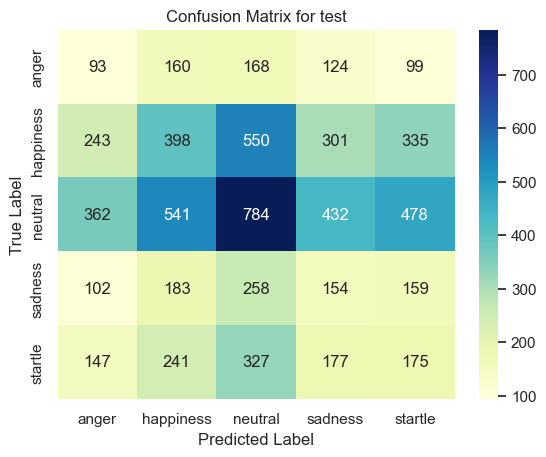

In [26]:
import seaborn as sns 
from sklearn.metrics import confusion_matrix

# Get the true labels and predicted labels for the test set
test_labels = test_generator.classes
test_pred_probs = model.predict(test_generator)
test_pred_labels = np.argmax(test_pred_probs, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(test_labels, test_pred_labels)
class_names = list(test_generator.class_indices.keys())
sns.set()
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='YlGnBu', 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for test')
plt.show()